In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm

from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
from scipy import interp
from itertools import cycle
import matplotlib.ticker as plticker

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_train = pd.read_csv(r"C:\Users\Harshit Gupta\Downloads\Malignant Comments Classifier Project\train.csv")
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [8]:
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
df_test = pd.read_csv(r"C:\Users\Harshit Gupta\Downloads\Malignant Comments Classifier Project\test.csv")
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


After checking through the tarining data when we take a look at the testing dataset we see that there are 1,53,164 rows and only 2 columns present in this dataframe. This gives us the idea that we will need to create additional columns to mark the comments into various categories as per our model confidence. Once again the id column does not seem to offer any significance and can be removed.

We can see that our training dataframe consists of 159571 rows and 8 columns in total.

Column Description:

 1) id : A unique id aligned with each comment text.
 2) comment_text : It includes the comment text.
 3) malignant : It is a column with binary values depicting which comments are malignant in nature.
 4) highly_malignant : Binary column with labels for highly malignant text.
 5) rude : Binary column with labels for comments that are rude in nature.
 6) threat : Binary column with labels for threatening context in the comments.
 7) abuse : Binary column with labels with abusive behaviour.
 8) loathe : Label to comments that are full of loathe and hatred.

In [10]:
df_train.isna().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

<AxesSubplot:>

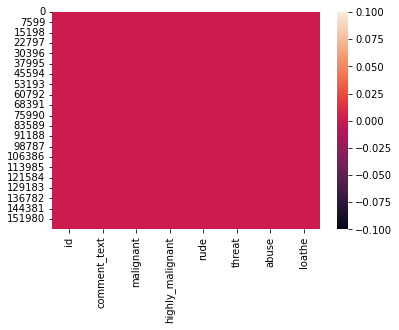

In [11]:
sns.heatmap(df_train.isnull())

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [13]:
# Creating function to see information of dataset
def features_info(dataset):
    
    print("\nRows in dataset =",dataset.shape[0])
    print("\nColumns in dataset =",dataset.shape[1])
    print("\nFeatures names =\n",dataset.columns)
    print("\nDataset types : \n",dataset.dtypes)
    print("\nNull values in dataset :\n",dataset.isnull().sum())
    print("\nAny duplicated values :",dataset.duplicated().values.any(),"\n")
    for i in dataset.columns:
        print("Total unique values in {} = {}".format(i,dataset[i].nunique()))

In [14]:
# Let's call the function
features_info(df_train)


Rows in dataset = 159571

Columns in dataset = 8

Features names =
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Dataset types : 
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Null values in dataset :
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

Any duplicated values : False 

Total unique values in id = 159571
Total unique values in comment_text = 159571
Total unique values in malignant = 2
Total unique values in highly_malignant = 2
Total unique values in rude = 2
Total unique values in threat = 2
Total unique values in abuse = 2
Total unique values in loathe = 2


In [15]:
df_test.shape

(153164, 2)

In [16]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

<AxesSubplot:>

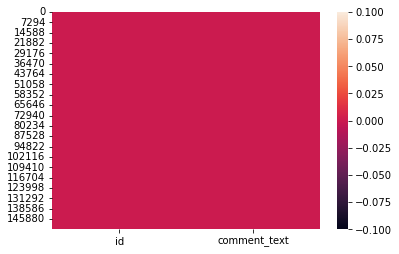

In [17]:

sns.heatmap(df_test.isnull())

In [18]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [19]:
# checking ratio of data which contains malignant comments and normal or unoffensive comments.
output_labels = df_train.columns[2:]

# counting non-zero rows i.e. Malignant Comments
malignant_comments = len(df_train[df_train[output_labels].any(axis=1)])

# counting rows containing zero i.e. Normal Comments
normal_comments = len(df_train)-malignant_comments

print(f"Total Malignant Comments: {malignant_comments} ({round(malignant_comments*100/len(df_train),2)}%)")
print(f"Total Normal Comments: {normal_comments} ({round(normal_comments*100/len(df_train),2)}%)")

Total Malignant Comments: 16225 (10.17%)
Total Normal Comments: 143346 (89.83%)


In [20]:
# checking the length of comments and storing it into another column 'original_length'
# copying df_train into another object df
df = df_train.copy()
df['original_length'] = df.comment_text.str.len()

# checking the first five and last five rows here
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [21]:
df_train.iloc[:,2:].sum()

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

In [22]:
df_train.describe()


,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df_test.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
freq,1,1


## Data Cleansing

In [24]:
df.drop(columns=['id'],inplace=True)

In [25]:
df['comment_text'] = df.comment_text.str.lower()
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


Since there was no use of the "id" column I have dropped it and converted all the text data in our comment text column into lowercase format for easier interpretation


## Text Preprocessing


### Removing and Replacing unwanted characters in the comment_text column


malignant


0    144277
1     15294
Name: malignant, dtype: int64


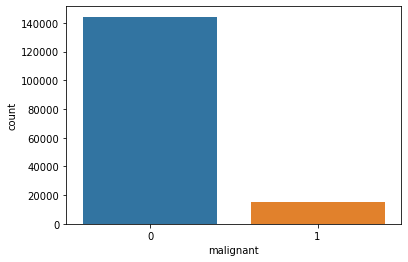

highly_malignant


0    157976
1      1595
Name: highly_malignant, dtype: int64


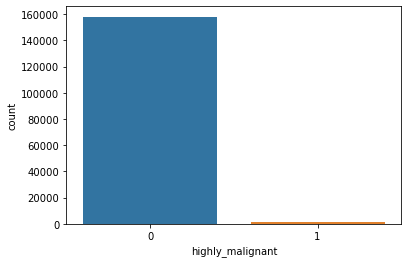

loathe


0    158166
1      1405
Name: loathe, dtype: int64


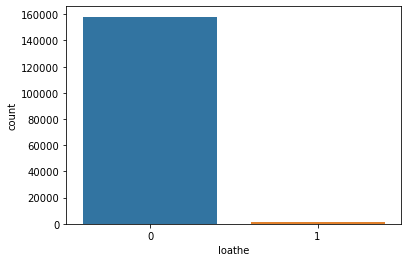

rude


0    151122
1      8449
Name: rude, dtype: int64


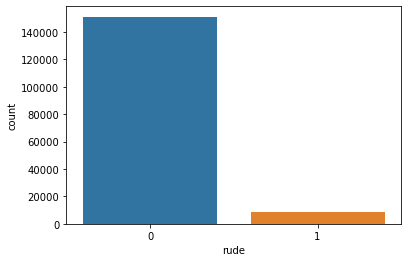

abuse


0    151694
1      7877
Name: abuse, dtype: int64


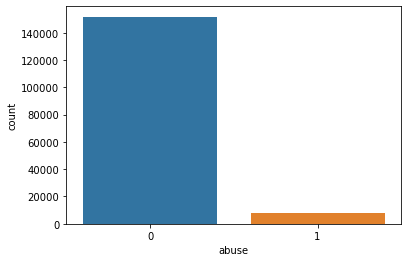

threat


0    159093
1       478
Name: threat, dtype: int64


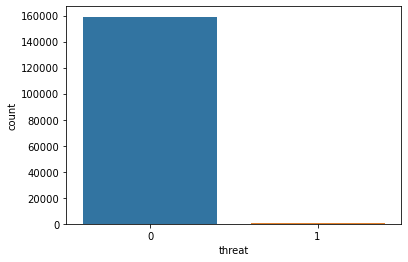

In [29]:
col_name=['malignant','highly_malignant','loathe','rude','abuse','threat']
for i in col_name:
    print(i)
    print("\n")
    print(df[i].value_counts())
    sns.countplot(df[i])
    plt.show()

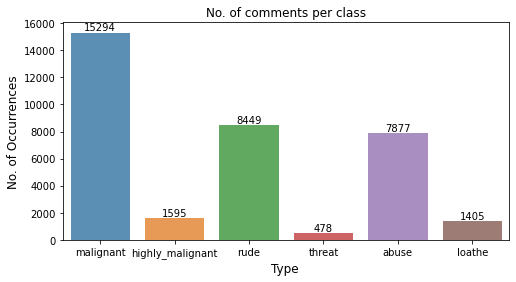

In [30]:
plt.figure(figsize=(8,4))
ax = sns.barplot(df_train.iloc[:,2:].sum().index, df_train.iloc[:,2:].sum().values, alpha=0.8)
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()


In [31]:
# Create a bar graph 
sum_mal = df_train['malignant'].sum() / len(df_train) * 100
sum_hig = df_train['highly_malignant'].sum() / len(df_train) * 100
sum_rude = df_train['rude'].sum() / len(df_train) * 100
sum_thr = df_train['threat'].sum() / len(df_train) * 100
sum_abu = df_train['abuse'].sum() / len(df_train) * 100
sum_loa = df_train['loathe'].sum() / len(df_train) * 100

In [32]:
# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

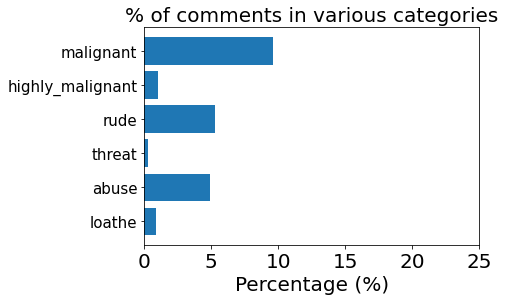

In [33]:
# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_mal, sum_hig, sum_rude, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=20)
plt.yticks(ind, ('malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe' ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

## Comparing normal comments and bad comments using count plot


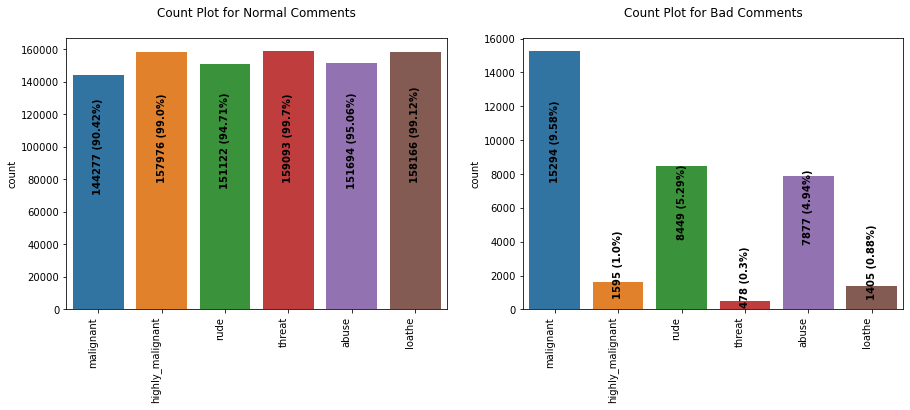

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

## Comparing the comment text length distribution before cleaning and after cleaning


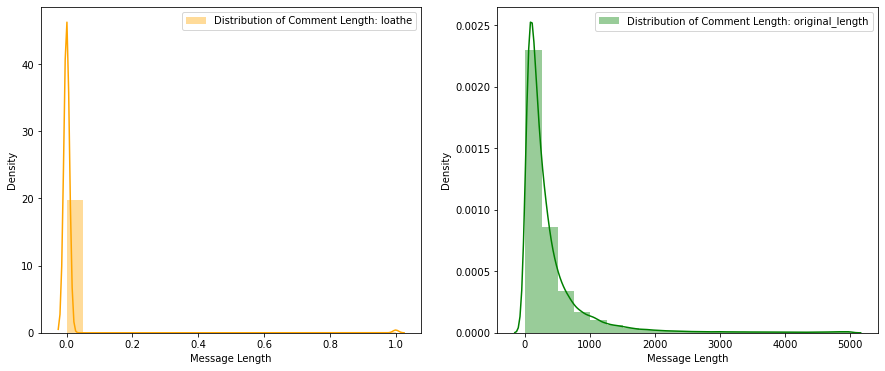

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

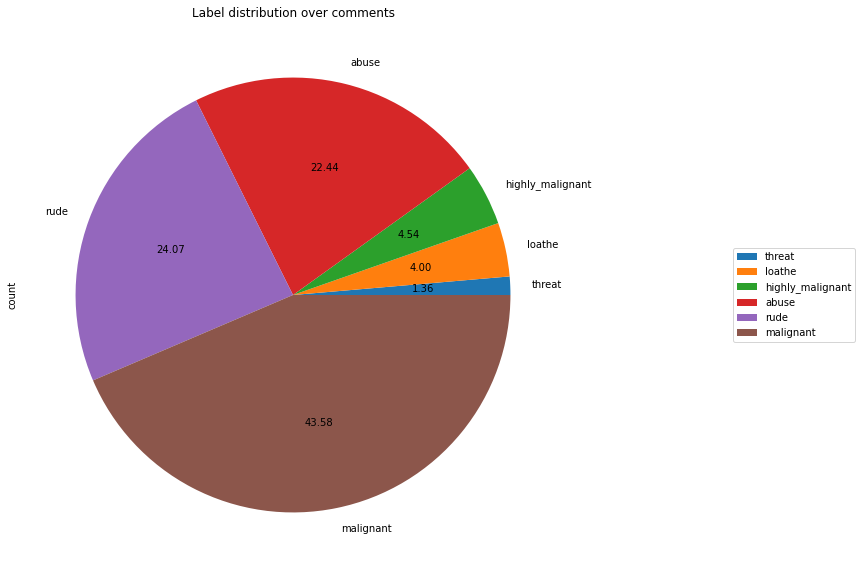

In [36]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df_train[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

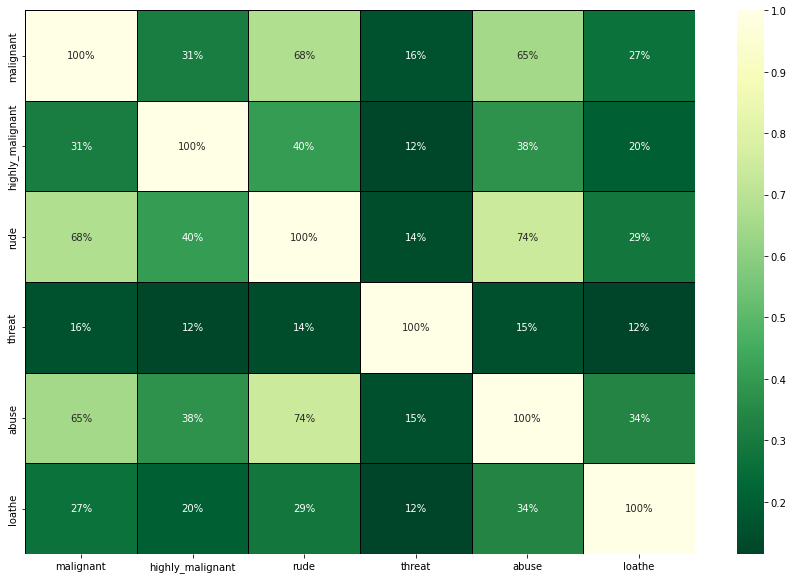

In [37]:
# Plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = df_train.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()